### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('5min').interpolate()
workload = workload[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-06 00:00:00,m_3330,26.0,93.0,NaN,NaN,55.96,48.37,5.0
1970-01-06 00:05:00,m_3330,27.0,93.0,NaN,NaN,55.96,48.37,4.0
1970-01-06 00:10:00,m_3330,38.0,95.0,NaN,NaN,55.97,48.38,7.0
1970-01-06 00:15:00,m_3330,30.0,92.0,NaN,NaN,55.97,48.39,5.0
1970-01-06 00:20:00,m_3330,33.0,95.0,NaN,NaN,55.98,48.39,6.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:35:00,m_3330,21.0,89.0,7.48,1.0,62.62,55.26,5.0
1970-01-08 23:40:00,m_3330,25.0,90.0,7.40,1.0,62.63,55.26,6.0
1970-01-08 23:45:00,m_3330,19.0,88.0,6.59,1.0,62.63,55.27,4.0


<AxesSubplot:xlabel='time_stamp'>

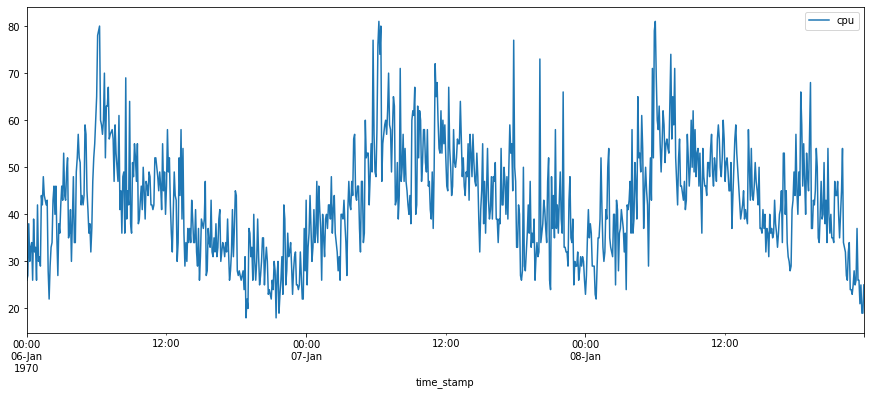

In [3]:
workload[['cpu']].plot(figsize=(15,6))

###  Separar treino e teste

In [4]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/3
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [5]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     43.478636
ar.L1      0.695895
sigma2    61.750876
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [6]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 5, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    # faz previsões
    X = [x for x in train_set]
    predictions = list()
    for i in range(len(test_set)):
        model = ARIMA(X, order=order, enforce_stationarity=False)
        model_fit = model.fit()
        predict = model_fit.forecast()[0]
        predictions.append(predict)
        X.append(test_set[i])
        
    # guarda os erros de cada previsão em uma lista
    error = np.sqrt(mean_squared_error(test_set, predictions))
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 10.941977838450185 | (0, 0, 1) 9.011959591820736 | (0, 0, 2) 8.523433469651845 | (0, 0, 3) 8.12520599496042 | (0, 0, 4) 7.857794870207851 | (0, 0, 5) 7.721103311493511 | (1, 0, 0) 7.846542720879827 | (1, 0, 1) 7.4333221954995805 | (1, 0, 2) 7.393050025897298 | (1, 0, 3) 7.3955577701601785 | (1, 0, 4) 7.363734354908823 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1, 0, 5) 7.3599780468339135 | (2, 0, 0) 7.578945960281296 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(2, 0, 1) 7.37896571240836 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 2) 7.377719064328396 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 3) 7.386311622570992 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 4) 7.360428979587684 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(2, 0, 5) 7.375763544880427 | (3, 0, 0) 7.417059035341966 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 1) 7.37906531341073 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 2) 7.411212743922994 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 3) 7.369241047692263 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 4) 7.349280405443474 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(3, 0, 5) 7.371745823645797 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(4, 0, 0) 7.440044427487275 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 1) 7.364856982870891 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 2) 7.381751501651702 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 3) 7.392621851624707 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 4) 7.389196299889328 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(4, 0, 5) 7.359163240284615 | (5, 0, 0) 7.436227820093895 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 1) 7.367191549277658 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 2) 7.374793500984298 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 3) 7.402015844652761 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 4) 7.3420802154883615 | 

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

(5, 0, 5) 7.364255164893294 | 

Melhor resultado:
	ordem: (5, 0, 4)
	erro: 7.3420802154883615


/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Execução do modelo com os melhores parâmetros

In [7]:
# modelo ARIMA
# faz previsões com a melhor ordem
order = best_order
X = [x for x in train_set]
predictions = list()
for i in range(len(test_set)):
    model = ARIMA(X, order=order, enforce_stationarity=False)
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    predictions.append(predict)
    X.append(test_set[i])

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/gsort/dev/python/cloud-predict/.cloud-predict/lib/python3.6/site-packages/statsmodels/base/model.py:56

### Comparar previsão x teste

In [8]:
results = pd.DataFrame({'Real':test_set, 'Predict':predictions})
results

,Real,Predict
time_stamp,,
1970-01-08 00:00:00,23.0,29.713346
1970-01-08 00:05:00,27.0,28.468643
1970-01-08 00:10:00,35.0,28.656295
1970-01-08 00:15:00,41.0,31.956311
1970-01-08 00:20:00,35.0,34.883229
...,...,...
1970-01-08 23:35:00,21.0,29.478601
1970-01-08 23:40:00,25.0,26.865058
1970-01-08 23:45:00,19.0,27.006741


<AxesSubplot:xlabel='time_stamp'>

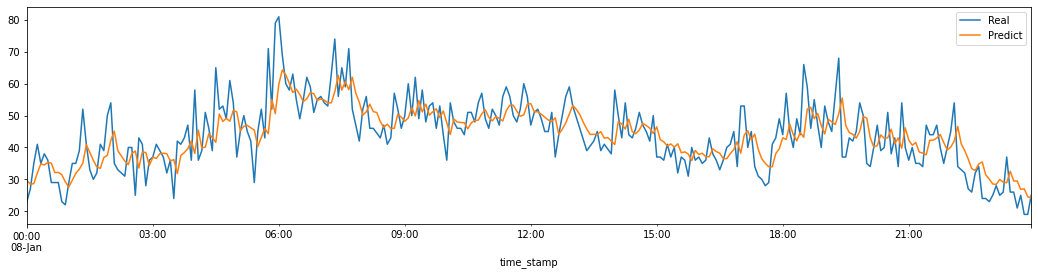

In [9]:
# compara a previsão com o conjunto de teste
results.plot(figsize=(18,4))

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')
validate(test_set, predictions)

mean_squared_error: 53.90614189066562
root_mean_squared_error: 7.3420802154883615
Determination coeficient: 0.5429339978298349
explained_variance_score: 0.5429375966276586
max_error: 28.389930913719823
mean_absolute_error: 5.658288569006576
